### jokes detection with Deep Learning

In [1]:
!pwd

/Users/tsung-chin.han/ZDOC/Berkeley/w266/project_selfcheck/cls


In [12]:
import pandas as pd
import numpy as np

import json

from matplotlib import pyplot as plt
%matplotlib inline


### load reddit_jokes

In [13]:
df = pd.read_json('reddit_jokes.json')
df.head()

,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”"
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...


(array([1.93449e+05, 6.59000e+02, 2.42000e+02, 1.13000e+02, 4.90000e+01,
        2.40000e+01, 1.10000e+01, 3.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([    0. ,  4852.6,  9705.2, 14557.8, 19410.4, 24263. , 29115.6,
        33968.2, 38820.8, 43673.4, 48526. ]),
 <a list of 10 Patch objects>)

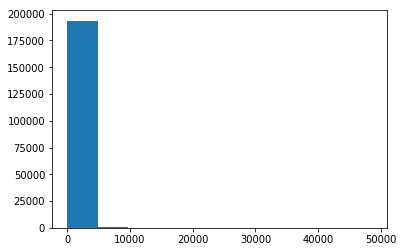

In [14]:
# orignial distributition
plt.hist(df.score)


In [15]:
# modeling score >= 10 | <10
df['is_joke'] = df.score.apply(lambda x: 1 if x >= 10 else 0)


(array([133075.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  61478.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

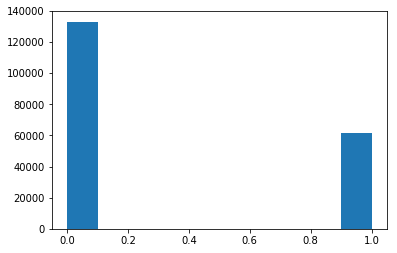

In [16]:
# modeling new binary distribution
plt.hist(df.is_joke)


In [17]:
# target
# df['target'] = 'title:' + df.title + ". " + "body:" + df.body
df['target'] = df.title + ". " + df.body


In [19]:
# finanl modeling dataset
final_modeling = df[['target', 'is_joke']]
print(final_modeling.shape)
final_modeling.head()


(194553, 2)


,target,is_joke
0,I hate how you cant even say black paint anymo...,0
1,What's the difference between a Jew in Nazi Ge...,0
2,I recently went to America..... ...and being t...,0
3,"Brian raises his hand and says, “He’s in Heave...",0
4,You hear about the University book store worke...,0


In [20]:
final_modeling.is_joke.value_counts()

0    133075
1     61478
Name: is_joke, dtype: int64

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras import backend as K


Using TensorFlow backend.


In [27]:
max(df.target.apply(lambda x: len(x)))

39744

### preprocess data

In [28]:
texts = df.target.values

In [32]:
df.is_joke.values

array([0, 0, 0, ..., 1, 1, 0])

### (current example from github)

In [33]:
# Tokenizing the data
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(df.is_joke.values)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 98403 unique tokens
Shape of data tensor: (194553, 50)
Shape of labels tensor: (194553,)


### Loading the pre-trained word embeddings
(this will be changed to GPT, but for now using glove from the example...)


In [36]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-03-25 22:21:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [40]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 
        # for words not in embedding index values will be zeros
        
        

Found 400000 word vectors:


IndexError: index 10000 is out of bounds for axis 0 with size 10000

### 1 - feed-forward network with dense layers on top of embedding layer

In [44]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()


W0325 22:37:51.530282 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0325 22:37:51.541852 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0325 22:37:51.558344 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0325 22:37:51.615498 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0325 22:37:51.629767 4539475392 deprecation.py:506] From /usr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________


In [45]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0325 22:38:36.998430 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0325 22:38:36.999905 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0325 22:38:37.000699 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0325 22:38:37.070448 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0325 22:38:37.072010 4539475392 module_wrapper.py:139] From /usr/local/lib/py

In [46]:
# to compute f-measure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [47]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)


W0325 22:39:22.789644 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0325 22:39:22.796127 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0325 22:39:22.801466 4539475392 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0325 22:39:23.058141 4539475392 module_wrapper.py:139] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0325 22:39:23.066

Train on 175097 samples, validate on 19456 samples
Epoch 1/20
175097/175097 [==============================] - 24s 139us/step - loss: 0.6104 - acc: 0.6842 - f1: 0.1761 - val_loss: 0.6015 - val_acc: 0.6879 - val_f1: 0.2748
Epoch 2/20
175097/175097 [==============================] - 23s 130us/step - loss: 0.5990 - acc: 0.6919 - f1: 0.2289 - val_loss: 0.5968 - val_acc: 0.6913 - val_f1: 0.2716
Epoch 3/20
175097/175097 [==============================] - 24s 139us/step - loss: 0.5924 - acc: 0.6975 - f1: 0.2504 - val_loss: 0.5964 - val_acc: 0.6939 - val_f1: 0.2263
Epoch 4/20
175097/175097 [==============================] - 24s 139us/step - loss: 0.5857 - acc: 0.7026 - f1: 0.2679 - val_loss: 0.5967 - val_acc: 0.6964 - val_f1: 0.2568
Epoch 5/20
175097/175097 [==============================] - 23s 129us/step - loss: 0.5787 - acc: 0.7092 - f1: 0.2929 - val_loss: 0.5967 - val_acc: 0.6956 - val_f1: 0.2066
Epoch 6/20
175097/175097 [==============================] - 23s 133us/step - loss: 0.5706 - ac

In [48]:
# helper function to plot the results
def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
  
    epochs = range(1, len(acc)+1)
    
    
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, f1, label='Training fmeasure')
    plt.plot(epochs, val_f1, label='Validation fmeasure')
    plt.title('Training and validation fmeasure')
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.legend()

    plt.show()
    

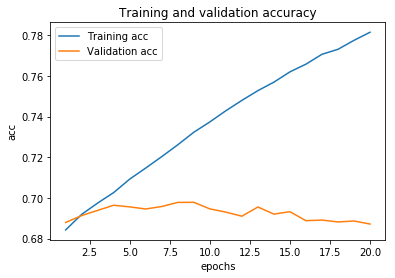

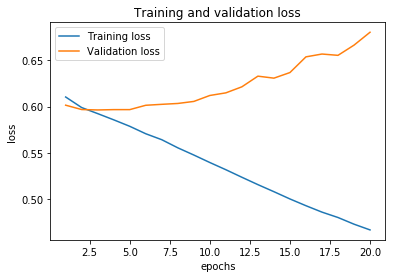

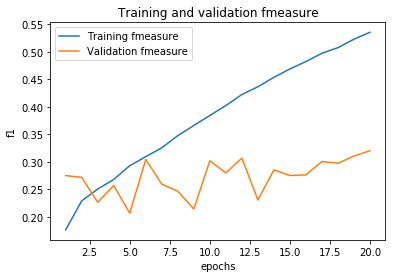

In [49]:
# plotting the results
plot_result(history)


### 2 - model without pre-trained word embeddings

In [50]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________
Train on 175097 samples, validate on 19456 samples
Epoch 1/20
175097/175097 [==============================] - 85s 488us/step - loss

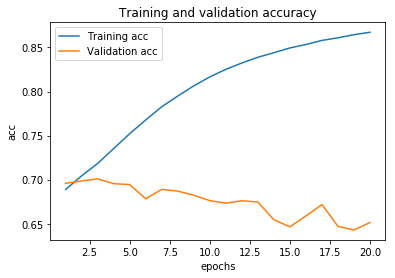

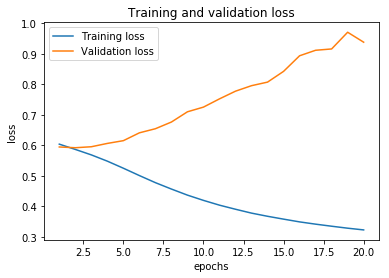

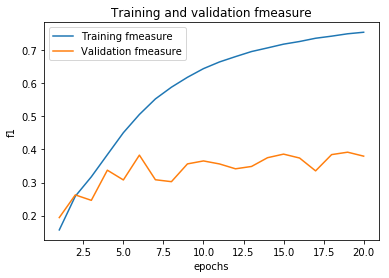

In [52]:
plot_result(history)


In [51]:
### discuss....

### 3 - RNN on top of embedding (check if we'd like to proceed)

### 4 - LSTM on top of embedding (check if we'd like to proceed)

### 5 - Conv layer on top of embedding (check if we'd like to proceed)